# Advanced ML

## Bayesian Time Series Analysis with Prophet

Prophet uses a decomposable time series model with three main model components: growth, seasonality and holidays. They are combined using the equation

$$y(t) = g(t) + s(t) + h(t) + e(t)$$

where $g(t)$ represents the growth function which models non-periodic changes, $s(t)$ represents periodic changes due to weekly or yearly seasonality, $h(t)$ represents the effects of holidays, and $e(t)$ represents the error term. 

Such decomposable time series are very common in forecasting and later in the article we will see how to tune each component of the above equation.

    Capacities
    Changepoints
    Holidays and seasonality
    Smoothing Parameters

## Stock Market Data

We aim to predict the daily adjusted closing prices of Vanguard Total Stock Market ETF (VTI), using data from the previous N days. In this experiment, we will use 6 years of historical prices for VTI from 2013–01–02 to 2018–12–28, which can be easily downloaded from yahoo finance

https://finance.yahoo.com/quote/VTI/history?p=VTI

In [3]:
#!pip install fbprophet
#conda install -c conda-forge fbprophet

In [55]:
import io
import requests
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [43]:
url="https://query1.finance.yahoo.com/v7/finance/download/VTI?period1=1540045030&period2=1589767430&interval=1d&events=history"

In [44]:
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [45]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,394.000000,394.000000,394.000000,394.000000,394.000000,3.940000e+02
mean,147.305279,148.212005,146.260634,147.328934,145.216993,4.012064e+06
std,11.186875,10.740387,11.578606,11.133879,11.588840,3.179929e+06
min,113.650002,114.900002,109.489998,111.910004,111.356850,1.171000e+06
25%,140.379997,141.644996,139.514996,140.622505,137.821228,2.217750e+06
50%,147.350006,148.010002,146.479996,147.470001,144.989823,2.947450e+06
75%,153.100006,153.737496,152.210003,153.049995,151.180241,4.304050e+06
max,171.960007,172.559998,171.770004,172.169998,171.318985,2.228330e+07


In [46]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-22,141.729996,141.940002,140.419998,140.789993,136.643494,3220600
1,2018-10-23,138.690002,140.669998,137.460007,139.960007,135.837982,4981600
2,2018-10-24,139.889999,140.089996,135.399994,135.610001,131.616089,6013700
3,2018-10-25,136.630005,138.960007,136.169998,138.160004,134.090973,4886000
4,2018-10-26,136.119995,137.529999,134.169998,135.770004,131.771393,6623500


In [47]:
#drop all columns except date and adj close
df = df.drop(['Open', 'High','Low', 'Close', 'Volume'], axis=1)

In [48]:
#rename dataframe columns
df.columns = ['ds','y']
df.head()

,ds,y
0,2018-10-22,136.643494
1,2018-10-23,135.837982
2,2018-10-24,131.616089
3,2018-10-25,134.090973
4,2018-10-26,131.771393


### Train Test Split

In [49]:
train_size = 252*3                     # Use 3 years of data as train set
val_size = 252                         # Use 1 year of data as validation set
train_val_size = train_size + val_size # Size of train+validation set
i = train_val_size                     # Day to forecast
H = 100                                # Forecast horizon

### Build Model

In [50]:
# Fit prophet model
m = Prophet()
m.fit(df[i-train_val_size:i])

# Create dataframe with the dates we want to predict
future = m.make_future_dataframe(periods=2*H)

# Eliminate weekend from future dataframe
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

# Predict
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


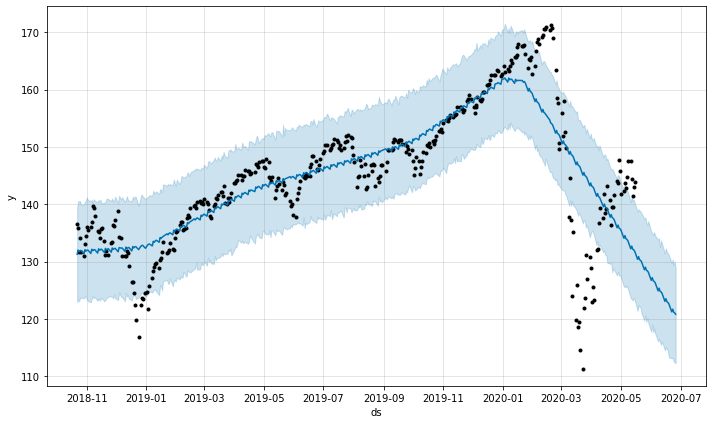

In [57]:
fig = m.plot(forecast)

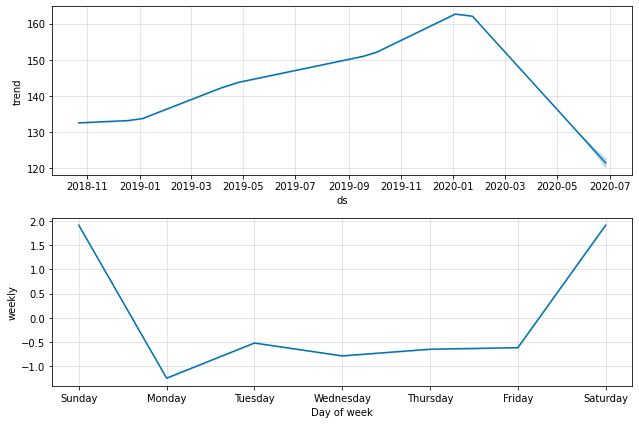

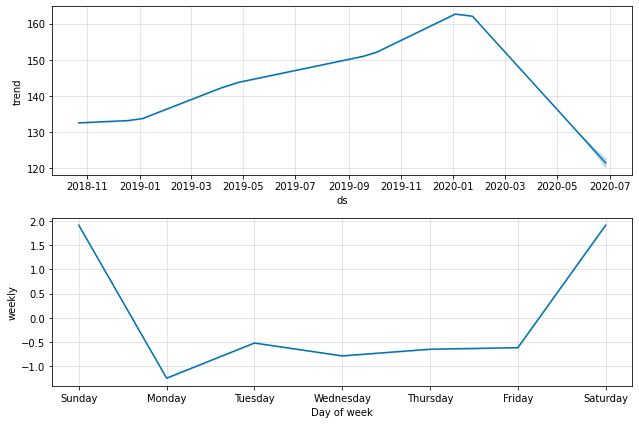

In [54]:
m.plot_components(forecast)

### Changepoint analysis

Time series usually have abrupt changes in their trajectories. Prophet by default employs automatic changepoint detection. 

However, the strength of this changepoint detection can be adjusted by using the parameter `changepoint_prior_scale`. Increasing `changepoint_prior_scale` will make the trend more flexible and result in overfitting. Decreasing the `changepoint_prior_scale` will make the trend less flexible and result in underfitting. By default, this parameter is set to 0.05.

In [70]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[[<matplotlib.lines.Line2D at 0x2ad93e5b6c8>],

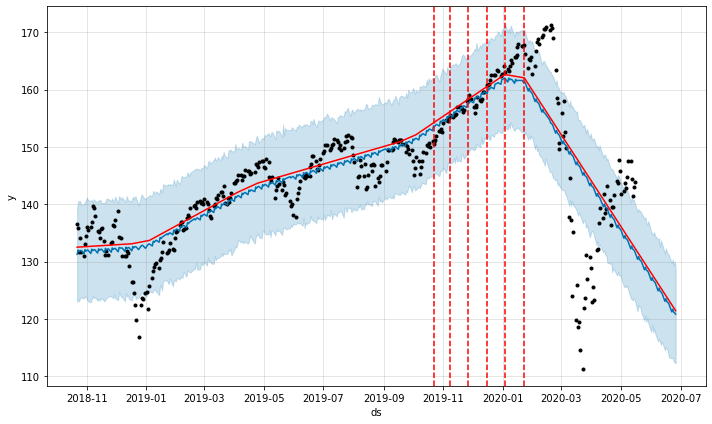

In [71]:
fig = m.plot(forecast)
add_changepoints_to_plot(fig.gca(), m, forecast)